In [1]:
from datetime import date
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack, ndimage
# from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [20]:
%matplotlib ipympl

# Load experiment list

In [5]:
data_dir = Path(r"P:\\")
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\subject_metadata.csv")
all_subexp = pd.read_csv(subject_csv)
all_subexp.head()

,mouse,sex,DOB,strain,exp_folder,histology,EEG,stim_tip_distance,tiparea,dist_CL,color
0,mouse771424,F,NaN,C57BL/6J,THstim_d1_2024-11-14_11-28-16,True,False,300,TH,0.925338,tomato
1,mouse771424,F,NaN,C57BL/6J,THstim_d2_2024-11-15_10-51-49,True,False,300,CP,1.494992,firebrick
2,mouse771425,F,NaN,C57BL/6J,THstim_d1_2024-11-21_10-59-24,True,False,300,PAL,1.286954,limegreen
3,mouse771425,F,NaN,C57BL/6J,THstim_d2_2024-11-22_10-49-58,True,False,300,int,1.435270,forestgreen
4,mouse771426,M,NaN,C57BL/6J,THstim_d1_2024-12-19_12-19-39,True,False,100,AV,0.686477,violet


# Test one session

In [6]:
choose_sub = 5
exprow = all_subexp.iloc[choose_sub]
data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)
exp_tag = exprow.exp_folder[:9]
print(exp_tag)

Experiment type: electrical stimulation
THstim_d2


## Load all data

### Stim log

In [7]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

In [8]:
simple_log_file = exp.stimulus_log_file[:exp.stimulus_log_file.find('estim_log')] + 'simple_' + exp.stimulus_log_file[exp.stimulus_log_file.find('estim_log'):]
if os.path.exists(simple_log_file):
    simple_log = pd.read_csv(simple_log_file)
elif os.path.exists(os.path.join(exp.data_folder, r'simple_estim_log.csv')):
    simple_log = pd.read_csv(os.path.join(exp.data_folder, r'simple_estim_log.csv'))
else:
    print('No simple log found')

### Running

In [9]:
running_file = os.path.join(exp.data_folder, 'raw_running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

### Iso times

In [10]:
iso_induction, iso_maintenance = exp.load_iso_times()

### Load probe LFP

In [11]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeA', 'probeD', 'probeE', 'probeF']


In [12]:
for probei in probe_list:
    print(probei)
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    probe_areas = np.array(data['area_ch'])
    print(np.unique(probe_areas))
    print('')

probeA
['ACAd5' 'ACAd6a' 'DP' 'ILA5' 'MOs1' 'MOs2/3' 'MOs5' 'OLF' 'PL5' 'PL6a'
 'STR' 'TTd' 'null']

probeD
['APN' 'CA1' 'DG-mo' 'HPF' 'NOT' 'ProS' 'SUB' 'VISp1' 'VISp2/3' 'VISp4'
 'VISp5' 'VISp6a' 'VISpm6a' 'VISpm6b' 'alv' 'dhc' 'fp' 'null' 'root'
 'scwm']

probeE
['CA1' 'CA2' 'CA3' 'LP' 'PO' 'SSp-bfd1' 'SSp-bfd2/3' 'SSp-bfd4' 'SSp-bfd5'
 'SSp-bfd6a' 'SSp-bfd6b' 'alv' 'ccb' 'null' 'or']

probeF
['ACAd6a' 'ACAd6b' 'ACAv6b' 'LSc' 'LSr' 'MOs1' 'MOs2/3' 'MOs5' 'MOs6a'
 'SEZ' 'STR' 'VL' 'ccg' 'cing' 'null']



In [22]:
probe_name = 'probeD'

## Load LFP as memmap ##
lfp_ts = np.load(exp.ephys_params[probe_name]['lfp_timestamps'])
lfp_data_mm = np.memmap(exp.ephys_params[probe_name]['lfp_continuous'], dtype='int16', mode='r').reshape(
    (len(lfp_ts), exp.ephys_params[probe_name]['num_chs']))

## Load probe_info.json ##
with open(exp.ephys_params[probe_name]['probe_info']) as data_file:
    data = json.load(data_file)
npx_allch = np.array(data['channel'])
surface_ch = int(data['surface_channel'])
allch_z = np.array(data['vertical_pos'])
ref_mask = np.array(data['mask'])
npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
probe_ch_depths = allch_z[surface_ch] - allch_z
probe_areas = np.array(data['area_ch'])

In [23]:
np.unique(probe_areas)

array(['APN', 'CA1', 'DG-mo', 'HPF', 'NOT', 'ProS', 'SUB', 'VISp1',
       'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISpm6a', 'VISpm6b', 'alv',
       'dhc', 'fp', 'null', 'root', 'scwm'], dtype='<U7')

In [24]:
area_chs = np.nonzero(probe_areas == 'MOs5')[0]
print(area_chs)

[]


## Load a single ch

Choose shortened timestamps

In [17]:
firstind = np.nonzero(stim_log.onset.values > iso_maintenance[0])[0][0]
tinds = np.nonzero(lfp_ts < stim_log.onset.values[firstind])[0]
lfpts_short = lfp_ts[tinds]

Choose the LFP that aligns

In [18]:
plot_ch = 380
lfpuv_ch = lfp_data_mm[tinds, plot_ch] * exp.ephys_params[probe_name]['bit_volts']

Text(0, 0.5, 'Speed (cm/s)')

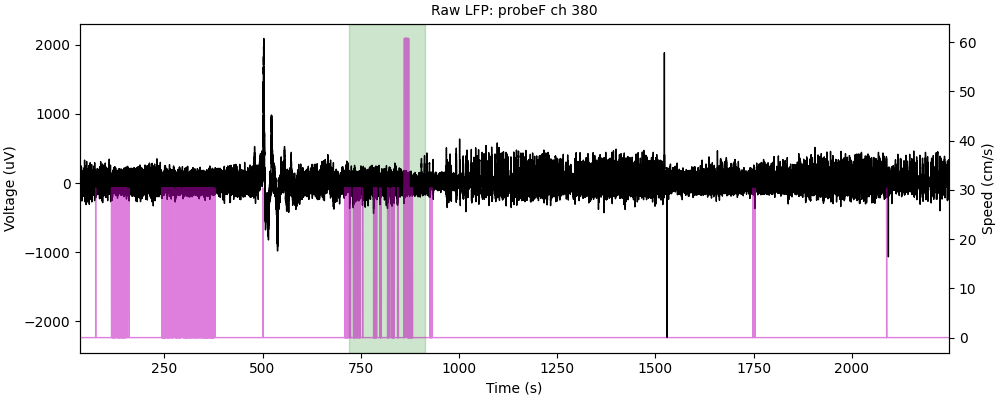

In [21]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(lfpts_short, lfpuv_ch, color='k', linewidth=1.0)
ax.axvspan(iso_induction[0], iso_induction[1], color='g', alpha=0.2)
ax.set_xlim([lfpts_short[0], lfpts_short[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Raw LFP: {} ch {:d}'.format(probe_name, plot_ch))
rax = ax.twinx()
rinds = np.nonzero(speedts < stim_log.onset.values[firstind])[0]
rax.plot(speedts[rinds], speed[rinds], color='m', linewidth=1.0, alpha=0.5)
rax.set_ylabel('Speed (cm/s)')

#### Apply reverse filter to correct for analog filter phase shift

In [22]:
hardware_filter = signal.butter(1, Wn=[0.5, 500], btype='band', fs=exp.ephys_params[probe_name]['lfp_sample_rate'])
# correct for analog filter phase shift
# reverse, filter in 1 direction, and reverse again
lfp_c = np.flip(signal.lfilter(*hardware_filter, np.flip(lfpuv_ch)))

Text(0.5, 1.0, 'Raw LFP: probeF ch 380')

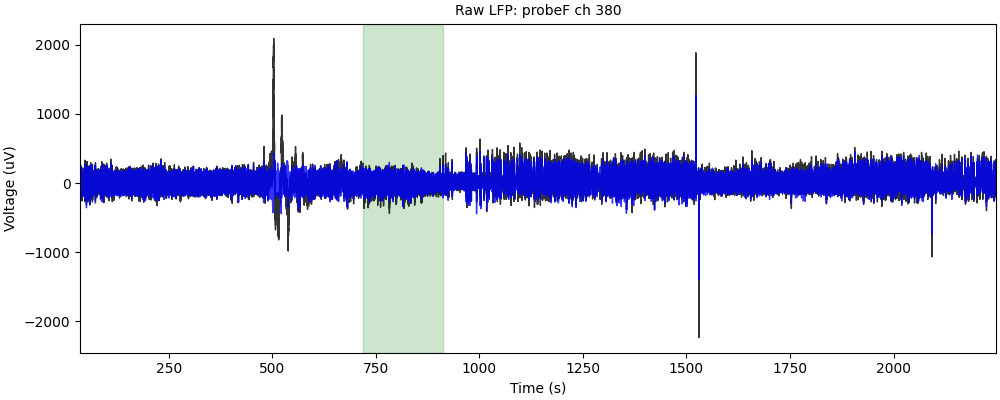

In [23]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(lfpts_short, lfpuv_ch, color='k', linewidth=1.0, alpha=0.8)
ax.plot(lfpts_short, lfp_c, color='b', linewidth=1.0, alpha=0.8)
ax.axvspan(iso_induction[0], iso_induction[1], color='g', alpha=0.2)
ax.set_xlim([lfpts_short[0], lfpts_short[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Raw LFP: {} ch {:d}'.format(probe_name, plot_ch))

#### Compare the spectra

In [29]:
frexa, Pxxa = signal.welch(
    lfpuv_ch, exp.ephys_params[probe_name]['lfp_sample_rate'], nperseg=2*exp.ephys_params[probe_name]['lfp_sample_rate'],
)
frexb, Pxxb = signal.welch(
    lfp_c, exp.ephys_params[probe_name]['lfp_sample_rate'], nperseg=2*exp.ephys_params[probe_name]['lfp_sample_rate'],
)

Text(0.5, 1.0, 'Raw LFP spectrum: probeF ch 380')

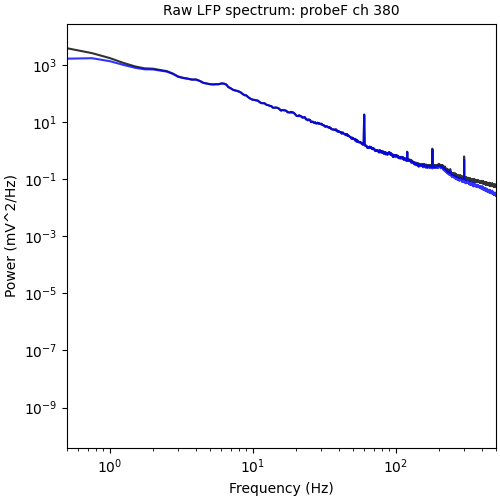

In [30]:
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
ax.loglog(frexa, Pxxa, color='k', linewidth=1.5, alpha=0.8)
ax.loglog(frexb, Pxxb, color='b', linewidth=1.5, alpha=0.8)
ax.set_xlim([0.5, 500])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Raw LFP spectrum: {} ch {:d}'.format(probe_name, plot_ch))

Test plot a chunk of the LFP

In [25]:
LFP_sample_rate = 1 / np.mean(np.diff(lfp_ts))
LFP_new_sample_rate = 500
downsample_factor = int(LFP_sample_rate / LFP_new_sample_rate)
print(downsample_factor)

5


In [26]:
num_samples = len(lfp_data_mm[:, 0][::downsample_factor])
num_channels = lfp_data_mm.shape[1]
lfp_subsampled = np.zeros((num_samples, num_channels), dtype='float')
for chi in range(num_channels):
    lfp_chi_raw = lfp_data_mm[:, chi] * exp.ephys_params[probe_name]['bit_volts']
    lfp_subsampled[:, chi] = signal.decimate(lfp_chi_raw, downsample_factor, ftype='iir', zero_phase=True)
LFP_new_timestamps = lfp_ts[::downsample_factor]

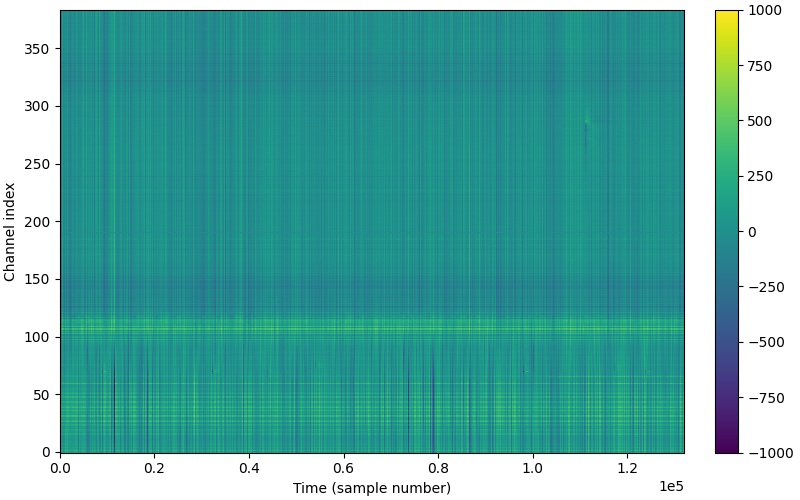

In [27]:
inds = LFP_new_timestamps < 300 # choose to load the first 120 s
LFP_data_chunk = lfp_subsampled[inds, :]

fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
im = ax.imshow(LFP_data_chunk.T, aspect='auto', origin='lower', vmin=-1e3, vmax=1e3, interpolation='none')
ax.set_xlabel('Time (sample number)')
ax.set_ylabel('Channel index')
cbar = fig.colorbar(im)

## Test all probe common average

Choose shortened timestamps

In [16]:
# firstind = np.nonzero(stim_log.onset.values > iso_maintenance[0])[0][0]
# twin = [iso_maintenance[0], stim_log.onset.values[firstind]]
twin = [1000, 1200]

In [17]:
all_lfp_list = []
all_ts_list = []
for ii, probei in enumerate(probe_list):
    print(probei)
    ## Load LFP as memmap ##
    lfp_ts = np.load(exp.ephys_params[probei]['lfp_timestamps'])
    lfp_data_mm = np.memmap(exp.ephys_params[probei]['lfp_continuous'], dtype='int16', mode='r').reshape(
        (len(lfp_ts), exp.ephys_params[probei]['num_chs']))
    print(lfp_data_mm.shape)
    ## Get timestamps in window ##
    if ii == 0:
        tinds = np.nonzero((lfp_ts > twin[0]) & (lfp_ts < twin[1]))[0]
    else:
        tstart = np.nonzero(lfp_ts > twin[0])[0][0]
        tinds = np.arange(tstart, tstart + len(all_ts_list[0]))
    all_ts_list.append(lfp_ts[tinds])
    all_lfp_list.append(lfp_data_mm[tinds, :] * exp.ephys_params[probei]['bit_volts'])
    print(len(tinds))
    print('')

probeA
(17263001, 384)
500001

probeD
(17263043, 384)
500001

probeE
(17262991, 384)
500001

probeF
(17262970, 384)
500001



In [18]:
allts = np.mean(np.array(all_ts_list), axis=0)
print(allts.shape)

(500001,)


In [19]:
alllfp = np.concatenate(all_lfp_list, axis=1)
print(alllfp.shape)

(500001, 1536)


Text(0.5, 1.0, 'Raw LFP: all chs')

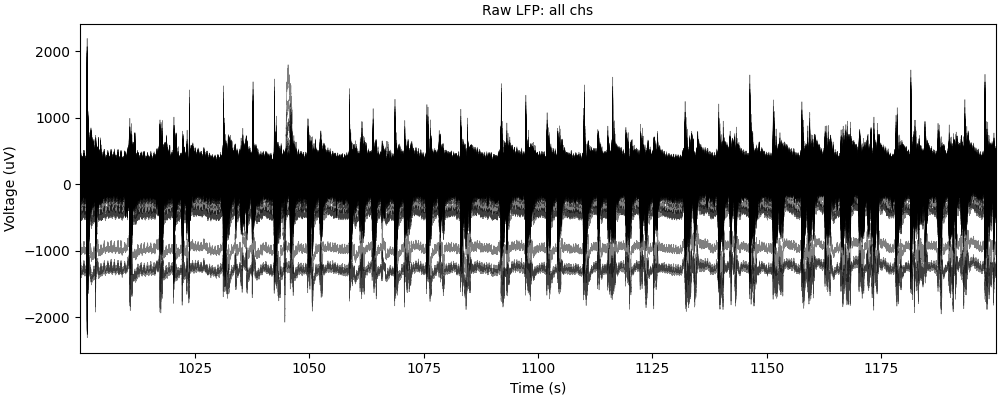

In [21]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(allts, alllfp, color='k', linewidth=0.5, alpha=0.5)
# ax.plot(lfpts_short, lfp_c, color='b', linewidth=1.0, alpha=0.8)

ax.set_xlim([allts[0], allts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Raw LFP: all chs')

Text(0.5, 1.0, 'Raw LFP: all chs')

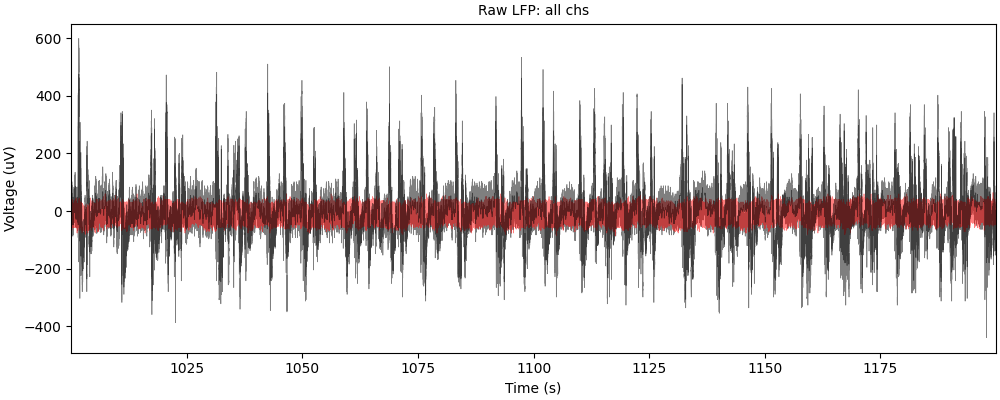

In [29]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(allts, alllfp[:, 150 + 384], color='k', linewidth=0.5, alpha=0.5)
# ax.plot(allts, alllfp[:, 190], color='r', linewidth=0.5, alpha=0.5)
ax.plot(allts, alllfp[:, 191 + 384], color='r', linewidth=0.5, alpha=0.5)
ax.plot(allts, alllfp[:, 250 + 384], color='k', linewidth=0.5, alpha=0.5)
# ax.plot(lfpts_short, lfp_c, color='b', linewidth=1.0, alpha=0.8)

ax.set_xlim([allts[0], allts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Raw LFP: all chs')

In [23]:
bugs = np.arange(0, alllfp.shape[1], 25)
print(bugs)

[   0   25   50   75  100  125  150  175  200  225  250  275  300  325
  350  375  400  425  450  475  500  525  550  575  600  625  650  675
  700  725  750  775  800  825  850  875  900  925  950  975 1000 1025
 1050 1075 1100 1125 1150 1175 1200 1225 1250 1275 1300 1325 1350 1375
 1400 1425 1450 1475 1500 1525]


In [28]:
refchs = 191 + (exp.ephys_params[probei]['num_chs'] * np.arange(0, 4))
print(refchs)

[ 191  575  959 1343]


In [30]:
refchs = 191 + (exp.ephys_params[probei]['num_chs'] * np.arange(0, 4))
gchs = np.array([x for x in np.arange(0, alllfp.shape[1]) if x not in refchs])
print(alllfp.shape[1])
print(len(gchs))

1536
1532


In [32]:
all_median = np.median(alllfp[:, gchs], axis=1)
print(all_median.shape)

(500001,)


Text(0.5, 1.0, 'Raw LFP: some chs and common median')

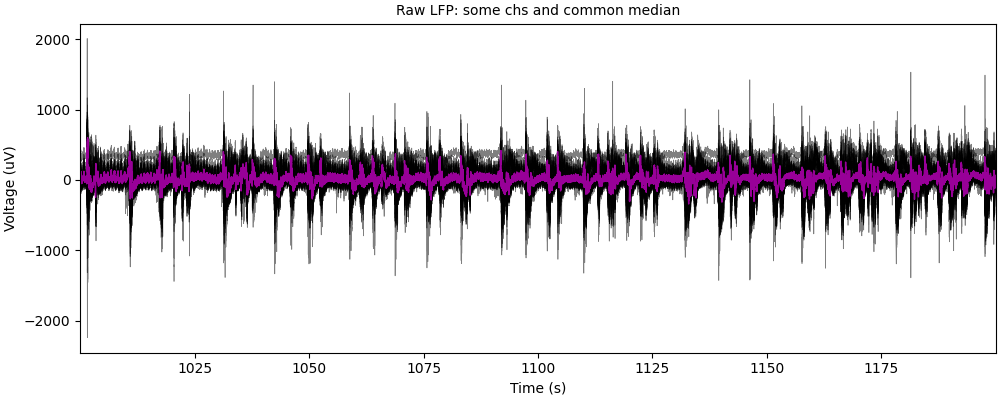

In [34]:
plotchs = np.array([x for x in np.arange(0, alllfp.shape[1], 40) if x not in refchs])

fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(allts, alllfp[:, plotchs], color='k', linewidth=0.5, alpha=0.5)
ax.plot(allts, all_median, color='m', linewidth=1.0, alpha=0.8)

ax.set_xlim([allts[0], allts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Raw LFP: some chs and common median')

In [36]:
CMRlfp = alllfp - all_median[:,None]

Text(0.5, 1.0, 'CMR LFP: some chs and common median')

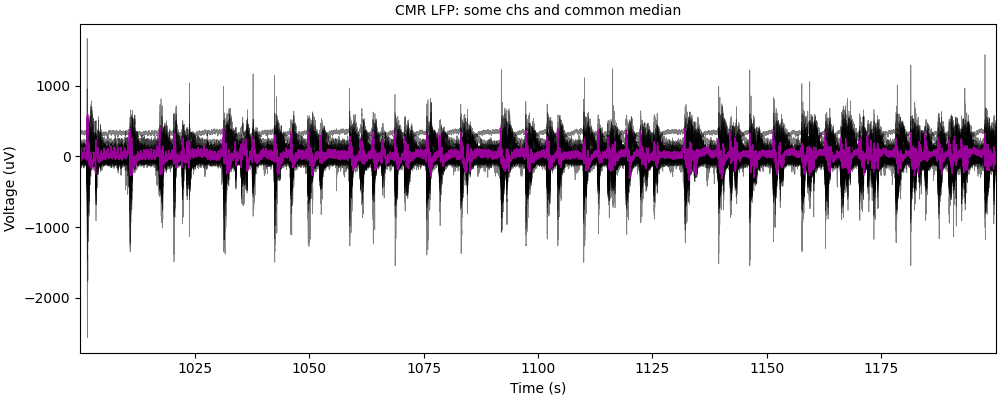

In [37]:
plotchs = np.array([x for x in np.arange(0, alllfp.shape[1], 40) if x not in refchs])

fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(allts, CMRlfp[:, plotchs], color='k', linewidth=0.5, alpha=0.5)
ax.plot(allts, all_median, color='m', linewidth=1.0, alpha=0.8)

ax.set_xlim([allts[0], allts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('CMR LFP: some chs and common median')

Text(0.5, 1.0, 'CMR LFP comparison: single ch and common median')

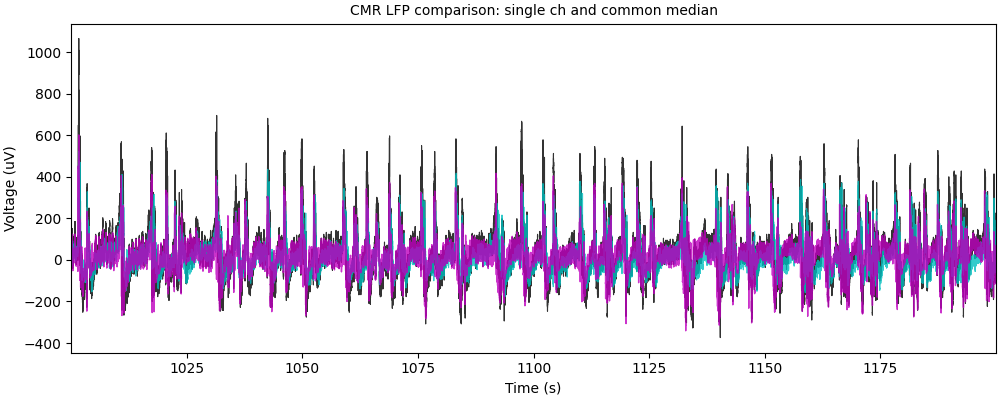

In [46]:
plot_ch = 1000

fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(allts, alllfp[:, plot_ch], color='k', linewidth=0.8, alpha=0.8)
ax.plot(allts, CMRlfp[:, plot_ch], color='c', linewidth=0.8, alpha=0.8)

ax.plot(allts, all_median, color='m', linewidth=1.0, alpha=0.8)

ax.set_xlim([allts[0], allts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('CMR LFP comparison: single ch and common median')

#### Compare the spectra

In [44]:
plot_ch = 1000
frexa, Pxxa = signal.welch(
    alllfp[:, plot_ch], exp.ephys_params[probe_name]['lfp_sample_rate'], nperseg=2*exp.ephys_params[probe_name]['lfp_sample_rate'],
)
frexb, Pxxb = signal.welch(
    CMRlfp[:, plot_ch], exp.ephys_params[probe_name]['lfp_sample_rate'], nperseg=2*exp.ephys_params[probe_name]['lfp_sample_rate'],
)

Text(0.5, 1.0, 'Raw LFP spectrum: probeF ch 1000')

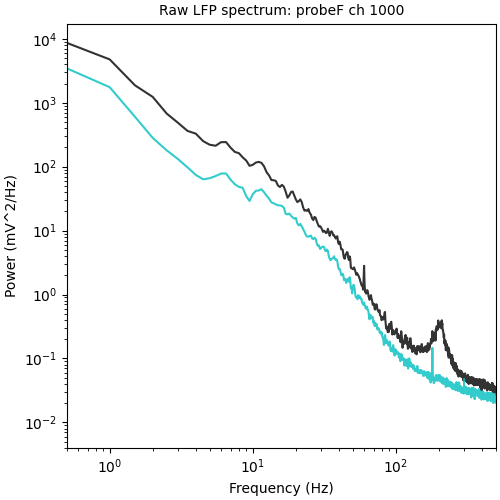

In [45]:
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
ax.loglog(frexa, Pxxa, color='k', linewidth=1.5, alpha=0.8)
ax.loglog(frexb, Pxxb, color='c', linewidth=1.5, alpha=0.8)
ax.set_xlim([0.5, 500])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Raw LFP spectrum: {} ch {:d}'.format(probe_name, plot_ch))

Get spectrum from rest, run, and iso

In [23]:
deltat = 10. # window size, s
awakebins = np.arange(lfp_ts[0], iso_induction[0], deltat)
firstind = np.nonzero(stim_log.onset.values > iso_maintenance[0])[0][0]
isobins = np.arange(iso_maintenance[0], stim_log.onset.values[firstind], deltat)

In [24]:
tempsp = []
for x in awakebins:
    tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
awakespeeds = np.array(tempsp)[:-1]

tempsp = []
for x in isobins:
    tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
isospeeds = np.array(tempsp)[:-1]

In [44]:
awake_Pxx = []
for timei in awakebins[:-1]:
    tinds = np.nonzero((lfp_ts >= timei) & (lfp_ts < timei + deltat))[0]
    frex, Pxx = signal.welch(
        lfpuv_ch[tinds], exp.ephys_params[probe_name]['lfp_sample_rate'], nperseg=2 * exp.ephys_params[probe_name]['lfp_sample_rate'],
    )
    awake_Pxx.append(Pxx)
awake_Pxx = np.array(awake_Pxx)
print(awake_Pxx.shape)
print(len(frex))

(68, 2501)
2501


In [45]:
iso_Pxx = []
for timei in isobins[:-1]:
    tinds = np.nonzero((lfp_ts >= timei) & (lfp_ts < timei + deltat))[0]
    frex, Pxx = signal.welch(
        lfpuv_ch[tinds], exp.ephys_params[probe_name]['lfp_sample_rate'], nperseg=2 * exp.ephys_params[probe_name]['lfp_sample_rate'],
    )
    iso_Pxx.append(Pxx)
iso_Pxx = np.array(iso_Pxx)
print(iso_Pxx.shape)

(133, 2501)


In [46]:
restPxx = np.mean(awake_Pxx[awakespeeds == 0, :], axis=0)
runPxx = np.mean(awake_Pxx[awakespeeds > 1, :], axis=0)
isoPxx = np.mean(iso_Pxx[isospeeds == 0, :], axis=0)

Text(0.5, 1.0, 'Raw LFP spectra: probeF, null')

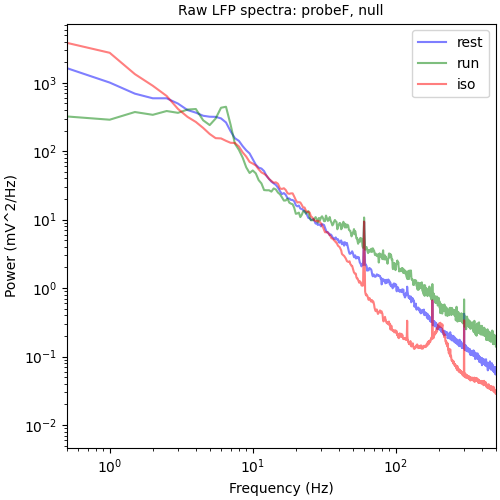

In [47]:
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
ax.loglog(frex, restPxx, color='blue', linewidth=1.5, alpha=0.5, label='rest')
ax.loglog(frex, runPxx, color='green', linewidth=1.5, alpha=0.5, label='run')
ax.loglog(frex, isoPxx, color='red', linewidth=1.5, alpha=0.5, label='iso')
ax.set_xlim([0.5, 500])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.legend()
ax.set_title('Raw LFP spectra: {}, {}'.format(probe_name, probe_areas[plot_ch]))

#### Load all chs

In [21]:
ch_selection = np.arange(0, exp.ephys_params[probe_name]['num_chs'], 50)
comavg = np.mean(lfp_data_mm, axis=1)

Text(0, 0.5, 'Voltage (bits)')

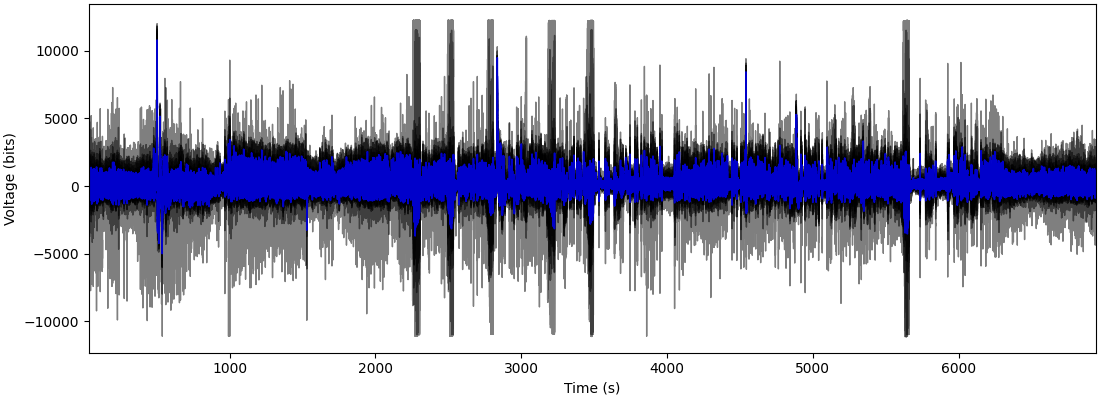

In [23]:
fig, ax = plt.subplots(figsize=(11,4), constrained_layout=True)
ax.plot(lfp_ts, lfp_data_mm[:, ch_selection], color='k', linewidth=1.0, alpha=0.5)
ax.plot(lfp_ts, comavg, color='b', linewidth=1.2, alpha=0.8)
ax.set_xlim([lfp_ts[0], lfp_ts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (bits)')

### Plot spectrum

Load all LFP chs and convert

In [17]:
all_lfpuv = lfp_data_mm * exp.ephys_params[probe_name]['bit_volts']

In [20]:
ch_selection = np.arange(0, exp.ephys_params[probe_name]['num_chs'], 20)
frex, Pxx = signal.welch(
    all_lfpuv[:,ch_selection], exp.ephys_params[probe_name]['lfp_sample_rate'], nperseg=2*exp.ephys_params[probe_name]['lfp_sample_rate'], axis=0
)

Text(0.5, 1.0, 'Raw LFP spectrum: probeE')

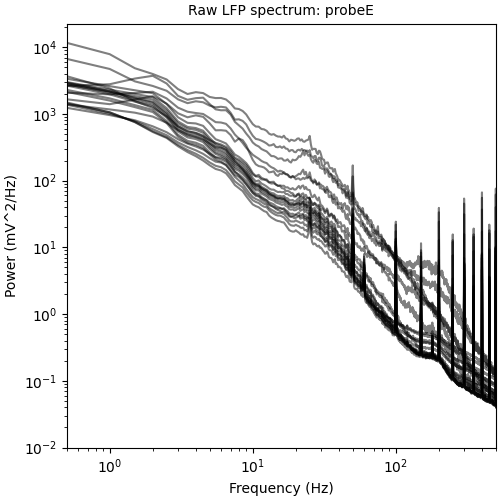

In [21]:
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
ax.loglog(frex, Pxx, color='k', linewidth=1.5, alpha=0.5)
ax.set_xlim([0.5, 500])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Raw LFP spectrum: {}'.format(probe_name))